# Soiaporn model

Prototype the Metropolis-within-Gibbs sampling technique presented in Soiaporn et al. 2012.

The full conditionals:

$$
F_T | f, \lambda, D \sim Gamma \bigg(N_C +1, \frac{1}{1/s + (1 - f)\epsilon_0 + f \sum_{k \geq 1} w_k \epsilon_k}\bigg)
$$

$$
P(\lambda_i | F_T, f, D) \propto \frac{f_{\lambda_i}}{\epsilon_{\lambda_i}} h_{\lambda_i}
$$

Where $h_{j} = (1 - f) \epsilon_0$ if $j = 0$ and $h_j = fw_j\epsilon_j$ if $j \geq 1$.

$$
P(f | \lambda, F_T, D) \propto e^{-F_T [  (1 - f)\epsilon_0  + f \sum_{k \geq 1} \epsilon_k w_k] } \times (1-f)^{m_0(\lambda) + b - 1}f^{N_C - m_0(\lambda)+a-1}
$$


$F_T$ and $\lambda$ are sampled directly from the gamma and multinomial distributions. $f$ is sampled using a random walk Metropolis algorithm with Gaussian proposals centred on the current value of $f$. The variance of the proposal distribution was tuned to give an acceptance rate of 25%.

$\kappa$ is treated specially, they consider a logarithmically spaced grid of values to condition on. So, treat $\kappa$ as fixed. 

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../fancy')
from fancy import Data
import pystan
import seaborn as sns
from metropolis_within_gibbs import *
from fancy.detector.auger import auger_location, theta_m, A, alpha_T, M, kappa_c

## Set up

Define input parameters and data. NB: $\alpha_T = 20370 km^2 sr year$ is defined in `soiaporn_functions.py`.

In [2]:
# fixed parameters
#kappa = 100
kappa_c = 9323

# hyperparametrs
a = 1 
b = a
s = 0.01 * 4 * np.pi

In [18]:
# load data
uhecr_file = 'data/augerUHECR_data2010.dat'
source_file = 'data/agn_catalog.dat'

data = Data()
data.add_source(source_file, 'AGN')
data.add_uhecr(uhecr_file, 'Auger2010')
data.add_detector(auger_location, theta_m, A, alpha_T, kappa_c, 'PAO')

N_C = len(data.uhecr.energy)
theta = np.deg2rad(data.uhecr.incidence_angle)
d = data.uhecr.unit_vector
varpi = data.source.unit_vector
D = data.source.distance
A = data.uhecr.A

In [4]:
# integral tables
from fancy.interfaces.integration import ExposureIntegralTable
from fancy.detector.auger import M, alpha_T, auger_params

my_table_file = 'tableforfig4.data.R'

params = auger_params

kappa = [10, 31.6, 100, 316, 1000]

#my_table = ExposureIntegralTable(kappa, varpi, params, filename = my_table_file)
#my_table.build()

eps = np.transpose(pystan.read_rdump(my_table_file)['table'])

## Recreate Fig. 4 in Soiaporn et al. 

Find the marginal posterior of $f$ for the different values of $\kappa$: [10, 31.6, 100, 316, 1000]. Use all the UHECR data.

In [5]:
sample_set = []
samplers = []
#for i in range(len(kappa)):

kappa = 10
eps_k = eps[0]

input_data = InputData(d, A, theta, varpi, D, eps_k)
input_parameters = InputParameters(kappa, kappa_c, a, b, s)
sampler = MetropolisWithinGibbs(input_data, input_parameters)
sampler.Sample(Niter = 2000, Nchain = 2)

#sample_set.append(sampler.total_samples)
#samplers.append(sampler)

Sampling completed
------------------
rhat f: 1.00
rhat F_T: 1.00
rhat lambda (avg): 1.00
accepted fraction: 0.20



/Users/fran/projects/bayes/astroparticle/soiaporn_model/metropolis_within_gibbs/autocorr.py:6: RuntimeWarning: invalid value encountered in double_scalars
  return S[0, 1] / np.sqrt(np.prod(np.diag(S)))


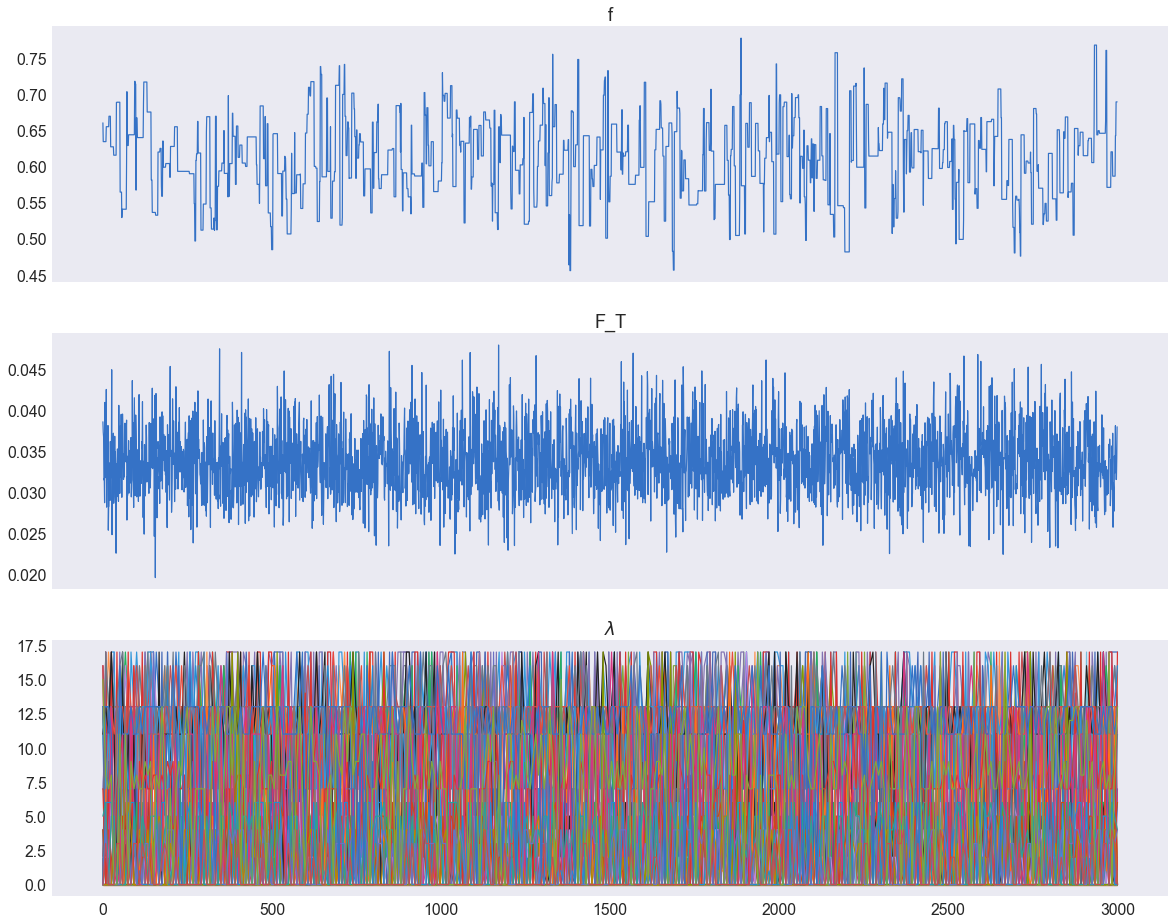

In [6]:
sns.set_style("dark")
#for s in samplers:
sampler.traceplot()

/Users/fran/projects/bayes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


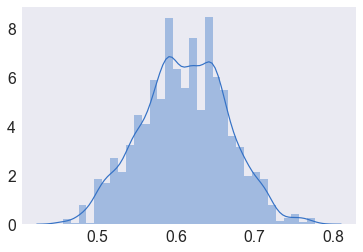

In [7]:
sns.distplot(sampler.total_samples.f)

In [ ]:
# plot
for i in range(len(sample_set)):
    sns.distplot(sample_set[i].f, label = '$\kappa$: ' + str(kappa[i]))
plt.legend()

In [ ]:
for i in range(len(sample_set)):
    plt.scatter(sample_set[i].f, sample_set[i].F_T, alpha = 0.1)

## Try on simulated data


In [13]:
from fancy import Model, Analysis

In [10]:
model_name = '../uhecr_model/stan/arrival_direction.stan'
sim_name = '../uhecr_model/stan/arrival_direction_sim.stan'

model = Model(model_name, sim_name)
model.compile()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_66bc8e0a4cc5364f4df10bd8a8065628 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fcec55134a247abeccf61caa0759ba3 NOW.


In [36]:
# create simulation to mimic data
Nsim = 100
F = Nsim * M / alpha_T
kappa = 10
f = 0.1
model.simulation_inputs(F, f, kappa, kappa_c)

In [37]:
analysis = Analysis(data, model)

# integral tables
table_file = '../uhecr_model/notebooks/data/table_50.data.R'
sim_table_file = '../uhecr_model/notebooks/data/table_sim.data.R'

#my_analysis.build_tables(50, table_file, sim_table_file)
# OR use tables already built
analysis.use_tables(table_file, sim_table_file)

# simulate
analysis.simulate(seed = 15071992)
sim_data_file = 'data/soiaporn_sim.data.R'
analysis.save_simulated_data(sim_data_file)

running stan simulation...
done
extracting output...
done
simulating zenith angles...


/Users/fran/projects/bayes/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


done
preparing fit inputs...
done


In [38]:
from fancy.detector.auger import A
d = analysis.detected.unit_vector
N_C = len(d)
varpi = data.source.unit_vector
D = data.source.distance
theta = analysis.zenith_angles
A = np.tile(A, N_C)

In [ ]:
eps_k = eps[0]

input_data = InputData(d, A, theta, varpi, D, eps_k)
input_parameters = InputParameters(kappa, kappa_c, a, b, s)
sampler = MetropolisWithinGibbs(input_data, input_parameters)
sampler.Sample(Niter = 2000, Nchain = 2)

In [ ]:
sns.set_style("dark")
#for s in samplers:
sampler.traceplot()

In [ ]:
sns.distplot(sampler.total_samples.f)